In [1]:
# Instal TensorFlow
!pip install tensorflow

In [2]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib 
import pandas as pd 
tf.__version__

'2.3.0'

In [3]:
# Import du dataset dans Pandas 
dataset = pd.read_csv("https://go.aws/314bBDq", error_bad_lines=False, encoding="utf-8")
dataset.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
1,e3be4f9c9e0b9572bfb2a5f88497bb14,NaN,2,2017-09-29 17:29:00,17:29,17,Ven,NaN,NaN,2017-09,0,0
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
3,fa330e5891a1bb486c3e9bf95c098726,NaN,5,2017-09-29 15:52:00,15:52,15,Ven,NaN,NaN,2017-09,0,0
4,c1a693206aee1a2412d4bd9e45b80ec5,NaN,3,2017-09-29 15:29:00,15:29,15,Ven,NaN,NaN,2017-09,0,0


4. We will need the reviews in French. Filter the reviews so that they are in the right language. 

In [4]:
# Taking only french reviews
french_reviews = dataset[dataset.review_lang == "french"]
french_reviews.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
11,726b1a3e2664e8b075129bcd643dbf56,En vacances en région parisienne nous nous som...,2,2017-09-29 00:37:00,00:37,0,Ven,en vacances en région parisienne nous nous som...,french,2017-09,172,25
12,8a71763fbb3da7436b957681b24cc404,Tropbeaufinalpleinlesyeuxoreil,5,2017-09-29 00:16:00,00:16,0,Ven,tropbeaufinalpleinlesyeuxoreil,french,2017-09,30,1
23,ce7abd7798ee036d667c0ad84b85daa7,L'univers Disney reste merveilleux. Toutefois ...,4,2017-09-28 20:24:00,20:24,20,Jeu,l univers disney reste merveilleux toutefois ...,french,2017-09,148,23


In [5]:
# Let's take the columns we're interested in 
french_reviews = french_reviews[["review_format", "stars"]]
french_reviews.head()

,review_format,stars
0,génial fabuleux exceptionnel j aimerais qu...,5
2,toujours aussi magic féerique,5
11,en vacances en région parisienne nous nous som...,2
12,tropbeaufinalpleinlesyeuxoreil,5
23,l univers disney reste merveilleux toutefois ...,4


In [6]:
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7MB 1.8MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=a61507f42c739b61557a695a02682e358eeac5d4b16542ac7a28d66eda40564e
  Stored in directory: /tmp/pip-ephem-wheel-cache-k8jjjlh1/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [7]:
# Import Spacy 
import fr_core_news_sm
nlp = fr_core_news_sm.load()

* Import french STOP_WORDS

In [8]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

In [9]:
#apply stop words
french_reviews["review_format_clean"] = french_reviews["review_format"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
french_reviews["review_format_clean"] = french_reviews["review_format_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
french_reviews["review_format_clean"] = french_reviews["review_format_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))

french_reviews

,review_format,stars,review_format_clean
0,génial fabuleux exceptionnel j aimerais qu...,5,génial fabuleu exceptionnel j aimerai w...
2,toujours aussi magic féerique,5,magic féerique
11,en vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...
12,tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil
23,l univers disney reste merveilleux toutefois ...,4,l univers disney merveilleux regrette qu fal...
...,...,...,...
295057,toujours aussi magique même si à la fin du séj...,5,magique fin séjour rotule lol
295549,séjour au top mes enfants les plus heureux ...,5,séjour top enfant heureux vouloir voir per...
298475,magnifique un monde parfait lt,5,magnifique monde parfaire lt
298832,oui j ai aimé car j adore disney et tout ce qu...,4,oui j aimer j adore disney touche univers ...


In [10]:
#tokenization
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(french_reviews.review_format_clean)
french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews.review_format_clean)
french_reviews["len_review"] = french_reviews["review_encoded"].apply(lambda x: len(x))
french_reviews = french_reviews[french_reviews["len_review"]!=0]

In [12]:
#padding
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(french_reviews.review_encoded, padding="post")

In [14]:
# creating the full dataset
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, french_reviews.stars.values-1))

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*french_reviews.shape[0])

train_data = full_ds_final.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds_final.skip(TAKE_SIZE)
test_data = test_data.batch(16)

In [ ]:
 # check a batch
for review, star in train_data.take(1):
  print(review, star)

tf.Tensor(
[[  18   20  187 ...    0    0    0]
 [  95   87   82 ...    0    0    0]
 [   8   21   25 ...    0    0    0]
 ...
 [ 829 1452   15 ...    0    0    0]
 [  17   52  210 ...    0    0    0]
 [  88    7  164 ...    0    0    0]], shape=(16, 91), dtype=int32) tf.Tensor([4 4 4 3 2 4 4 4 2 3 3 1 2 0 4 4], shape=(16,), dtype=int64)


In [ ]:
len(french_reviews)

8467

In [ ]:
#prepare the model 
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(encoder.vocab_size, 64, input_shape=[review.shape[1],]),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),  

                  # flatten output
                  tf.keras.layers.Flatten()   ,       

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(5, activation="softmax")
                                              
])

In [ ]:
vocab_size

10337

In [ ]:
(10337+1)*64+64

661696

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          661696    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          6160      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         41472     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [ ]:
# set up the learning rate (lr)
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.96,
    staircase=True)

# set up the optimizer
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# add weight to classes 
class_weight = {
    0:2,
    1:2,
    2:1,
    3:0.75,
    4:0.5
}

In [ ]:
# model training
history = model.fit(train_data, 
                    epochs=40, 
                    validation_data=test_data,
                    class_weight=class_weight)

Epoch 1/40


KeyboardInterrupt: ignored

In [ ]:
#check a prediction
for example, label in test_data.take(1):
  print(encoder.decode(example.numpy()[0]))
  print("Prediction : {}".format(model.predict_classes(example)[0]))
  print("Real: {}".format(label[0]))

beaucoup UNK d UNK momentanément UNK UNK c UNK UNK UNK UNK UNK UNK UNK c UNK nécessaire UNK veux bien comprendre UNK UNK UNK plein pot
Prediction : 3
Real: 2


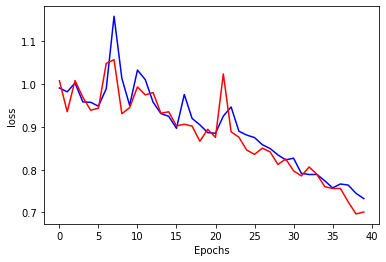

In [ ]:
#graph to compare test and train
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

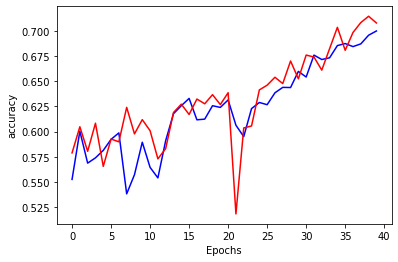

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()